In [6]:
#FUNCIONES DE ACTIVACIÓN PARA REDES NEURONALES MULTICAPA
import random as rd
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit,softmax

class function(object):
    def __init__(self,funcion,derivative=None,rand_init=(0,1)):
        self.F=funcion
        self.D=derivative
        self.Rand_init=rand_init

lineal=function(funcion=lambda x:x,
                derivative=lambda x:1,
                rand_init=(-1,1))

sigm=function(funcion=lambda x: expit(x),
              derivative=lambda x: expit(x)*(1-expit(x)),
              rand_init=(0,1))

tanh=function(funcion=lambda x:(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)),
              derivative=lambda x:1-((np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)))**2,
              rand_init=(-1,1))

tanh1=function(funcion=lambda x:np.tanh(x),
               derivative=lambda x:1-np.tanh(x)**2,
               rand_init=(-1,1))

relu=function(funcion=lambda x: np.maximum(0, x),
              derivative=lambda x: np.where(x<=0,0,1),
              rand_init=(0,1))

softmaxf=function(funcion=lambda x: softmax(x),
                  derivative=lambda x:softmax(x)*(1-softmax(x)),
                  rand_init=(0,1))


# funciones de coste
mse=function(funcion=lambda Yp, Yr: np.mean((Yp - Yr) ** 2) ,
                 derivative=lambda Yp, Yr: (Yp - Yr))

cross_entropy=function(funcion=lambda yscore,yreal:-np.sum(yreal*np.log(yscore))/yscore.shape[0],
                       derivative=lambda yscore,yreal:yscore-yreal)

Funciones={"relu":relu,
           "sigm":sigm,
           "relu":relu,
           "tanh":tanh,
           "tanh1":tanh1,
           "lineal":lineal,
           "softmax":softmaxf}

Loss={"mse":mse,
      "cross_entropy":cross_entropy}

_x = np.linspace(-10, 10, 100)



In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
Min_Max = preprocessing.MinMaxScaler()
Ordinal =preprocessing.OrdinalEncoder()


def one_hot_cols(df,cols_to_one):
    one_hot=pd.get_dummies(df,cols_to_one,columns=cols_to_one)
    return one_hot

def fit_cols(df, cols_to_fit,fit_function ):
    for col in cols_to_fit:
        df[col] = pd.DataFrame(fit_function.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

def split_Dataset(mypandas, cols_for_Y,size=0.2,state=1):
    
    X =  mypandas.drop(cols_for_Y, axis=1)
    Y = mypandas[cols_for_Y]
    X.head()

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size, random_state=state)
    X_train, X_testVal, Y_train, Y_testVal = train_test_split(X_train, Y_train, test_size=0.1, random_state=state)
    return X_train.to_numpy(), X_test.to_numpy(), Y_train.to_numpy(), Y_test.to_numpy(), X_testVal.to_numpy(), Y_testVal.to_numpy() 

In [8]:
#Hacer aquí la normalizacion de los datos
#modificar el split para hacer el vaidation 
import csv
data = pd.read_csv('datasets/Social_Network_Ads.csv', encoding='utf-8' )
data
print(data.shape)
data=one_hot_cols(data,['Purchased','Gender'])
dataset= fit_cols(data,data.columns,Min_Max)
Xtrain,X_test , Ytrain, Y_test, X_trainVal, Y_trainVal= split_Dataset(data,['Purchased_0','Purchased_1'])
print(Xtrain.shape)
print(Ytrain.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_trainVal.shape)
print(Y_trainVal.shape)
display(Xtrain)

(400, 5)
(288, 5)
(288, 2)
(80, 5)
(80, 2)
(32, 5)
(32, 2)


array([[0.12188842, 0.66666667, 0.43703704, 1.        , 0.        ],
       [0.91978177, 0.71428571, 0.88148148, 1.        , 0.        ],
       [0.11294846, 0.5       , 0.44444444, 1.        , 0.        ],
       ...,
       [0.94537049, 0.07142857, 0.42222222, 0.        , 1.        ],
       [0.14737655, 0.35714286, 0.20740741, 0.        , 1.        ],
       [0.65983094, 0.54761905, 0.27407407, 0.        , 1.        ]])

In [20]:
# CLASE DE LA CAPA DE LA RED
from IPython.display import clear_output
import time

class neural_layer(object):
    def __init__(self, n_conn, n_neur, activation="relu"):
        self.act = Funciones[activation]
        self.activation=activation
        self.random=self.act.Rand_init  
        self.shape=(n_conn,n_neur)
        self.Initialize()
        
    def show(self,Full=False):
        print(f"Pesos shape:{np.shape(self.W)} bias shape:{np.shape(self.b)} Activation:{self.activation}")
        print(f"Activation:{self.activation}, Random:{self.random}")
        print("______________________")
        if Full:
            print(f"Pesos:")
            print(self.W)
            print("#####")
            print(f"Bias:")
            print(self.b)
            
    def Initialize(self):
        #inicializa los pesos iniciales con aleatorios
        self.b = np.random.uniform(*self.random,(1, self.shape[1]))      
        self.W = np.random.uniform(*self.random,self.shape)
        
        
        
#CLASE RED NEURONAL MULTICAPA        
class Neural_Net(object):
    def __init__(self,Input,loss):
        self.loss = Loss[loss]
        self.Funcion_Loss=loss
        self.Input=Input
        self.NN=None;
              
    def Add_Layer(self,Num_neurons, function):
        if self.NN is None:
            self.NN=[]
            self.NN.append(neural_layer(self.Input,Num_neurons,function))
        else:
            _,L_input=np.shape(self.NN[-1].W)
            self.NN.append(neural_layer(L_input,Num_neurons,function))
            
    def Show_Model(self, Full=False):
        print(f"Input shape:{self.Input}, Loss: {self.Funcion_Loss}")
        for i,L in enumerate(self.NN):
            print(F"Layer_{i}:")
            L.show(Full)
            
            
    # fucnción de predicción (fordware pass)    
    def Predict(self,X):  
      #sólo podemos pasar Numpy  
      sx=np.shape(X)
      X=X.reshape(1,sx[0])
      if self.NN is None:
          print("error in Predict Method ( not NEURAL network available)")
          return 0
        
      out = [(None, X)] #primer data necesario
      # Forward pass
      for l, layer in enumerate(self.NN):
          z = out[-1][1] @ self.NN[l].W + self.NN[l].b
          a = self.NN[l].act.F(z)
          out.append((z, a))
      return out[-1][1]
    
    
    # función retropropagación del error
    def _backward_pass(self, X, Y,lr=0.01):
      sx=np.shape(X)
      sy=np.shape(Y)   
      X=X.reshape(1,sx[0])
      Y=Y.reshape(1,sy[0])

      # Forward pass
      out = [(None, X)] #primer data necesario
      for l, layer in enumerate(self.NN):
            z = out[-1][1] @ self.NN[l].W + self.NN[l].b
            a = self.NN[l].act.F(z)
            out.append((z, a))

      # Backward pass 
      deltas = []
      for l in reversed(range(0, len(self.NN))):
        z = out[l+1][0]
        a = out[l+1][1]
        if l == len(self.NN) - 1:
            deltas.insert(0, self.loss.D(a, Y) * self.NN[l].act.D(a)) # La última capa
        else:
            deltas.insert(0, deltas[0] @ _W.T * self.NN[l-1].act.D(a))
        _W = self.NN[l].W #los pesos en la capa superior
 
        # Gradient descent. actualizamos pesos 
        self.NN[l].b = self.NN[l].b - (deltas[0]* lr)
        self.NN[l].W = self.NN[l].W - (lr * (out[l][1].T @ deltas[0]))
      return out[-1][1]

    # función de entrenamiento de la red
    def Train(self,X,Y,valX=None,valY=None,lr=0.01,epoch=10,batch_size=1):
        H_loss = []
        H_acc=[]
        H_ValAcc=[]
        H_ValLoss=[]
        # inicializamos las capas neuronales a valores ramdom del rango de la función
        for Layer in self.NN:
            Layer.Initialize()
            
        for i in range(epoch):
            account=0
            epoch_Loss=0
            epoch_Acc=0
            loss_Val=0
            acc_val=0
            k=0
            # Entrenemos a la red! con el dataset de validación
            for j in range(len(X)):
                pY = self._backward_pass(X[j,:], Y[j,:],lr)#fila, fila, learning rate
                epoch_Loss+=self.loss.F(pY[0],Y[j,:])
                if (Y[j,:]==np.round(pY)).all():#condicion de acertar
                    epoch_Acc+=1
                
            for k in range(len(valX)):
                pY=self.Predict(valX[k])
                loss_Val+=self.loss.F(pY[0],valY[k,:])
                if (valY[k,:]==np.round(pY)).all():#condicion de acertar
                    acc_val+=1
                    
            H_ValAcc.append(acc_val/len(valY)*100)    
            H_ValLoss.append(loss_Val/len(valY))#media del error  
            H_acc.append(epoch_Acc/len(Y)*100)    
            H_loss.append(epoch_Loss/len(Y))#media del error  
            
            
            #imprimimos por pantalla resultados
            print("Epoch={}, Accurary={} Loss={} Vacc={} Vloss={}".format(i,round(H_acc[-1],3),round(H_loss[-1],7),round(H_ValAcc[-1],3),round(H_ValLoss[-1],7)))
            clear_output(wait=True)
        print("Epoch={}, Accurary={} Loss={} Vacc={} Vloss={}".format(i,round(H_acc[-1],3),round(H_loss[-1],7),round(H_ValAcc[-1],3),round(H_ValLoss[-1],7)))
        return H_loss,H_acc,H_ValLoss,H_ValAcc

    
# VISUALIZACIÓN Y TEST
def Show_Loss_Acc(H_loss,H_acc,V_loss,V_acc):
    plt.plot(range(len(H_loss)), H_loss,"tab:blue")
    plt.plot(range(len(V_loss)), V_loss,"tab:green")
    plt.ylabel("loss function ")
    plt.xlabel("EPOCH NUMBER")
    plt.show()
    plt.plot(range(len(H_acc)), H_acc, "tab:red")
    plt.plot(range(len(V_acc)), V_acc, "tab:green")
    plt.ylabel("ACCURACY")
    plt.xlabel("EPOCH NUMBER")
    plt.show()
       
def print_predict(neural_net,X,Y):
    for i in range(len(X)):
        sal_float=neural_net.Predict(X[i])
        sal=np.round(sal_float)
        
        if (Y[i]==np.round(sal)).all():
            print("Input:{}-- Real:{} predict: {} predict_float:{}".format(X[i],Y[i],sal,np.round(sal_float,2)))
        else:
            print("\x1b[31m Input:{}-- Real:{} predict: {} predict_float:{}\x1b[0m".format(X[i],Y[i],sal,np.round(sal_float,2)))


        

In [33]:
#DEFINIMOS LOS MODELOs
def Model1():
    red=Neural_Net(Input=5,loss="cross_entropy")
    red.Add_Layer(10,"relu")
    red.Add_Layer(2,"softmax")
    return red

def Model2():
    red=Neural_Net(Input=5,loss="mse")
    red.Add_Layer(15,"tanh")
    red.Add_Layer(20,"tanh1")
    red.Add_Layer(2,"sigm")
    return red

def Model3(): 
    red=Neural_Net(Input=5,loss="cross_entropy")
    red.Add_Layer(10,"sigm")
    red.Add_Layer(20,"tanh")
    red.Add_Layer(8,"relu")
    red.Add_Layer(2,"softmax")
    return red

In [34]:
cnn=Model2()
cnn.Show_Model()
cnn.Show_Model(True)

Input shape:5, Loss: mse
Layer_0:
Pesos shape:(5, 15) bias shape:(1, 15) Activation:tanh
Activation:tanh, Random:(-1, 1)
______________________
Layer_1:
Pesos shape:(15, 20) bias shape:(1, 20) Activation:tanh1
Activation:tanh1, Random:(-1, 1)
______________________
Layer_2:
Pesos shape:(20, 2) bias shape:(1, 2) Activation:sigm
Activation:sigm, Random:(0, 1)
______________________
Input shape:5, Loss: mse
Layer_0:
Pesos shape:(5, 15) bias shape:(1, 15) Activation:tanh
Activation:tanh, Random:(-1, 1)
______________________
Pesos:
[[-0.85318523  0.23570234 -0.33642116  0.13401446 -0.87242458 -0.28078142
  -0.73005761 -0.99338808  0.01043908  0.98401579 -0.42809832 -0.48373266
   0.72524813  0.68019429 -0.66596748]
 [ 0.25741718 -0.74547267  0.98527341 -0.54724654 -0.0251593   0.94003873
  -0.22788193  0.28228942 -0.57639133 -0.64860171 -0.27535057  0.52631172
   0.9299623   0.5348852  -0.62305274]
 [-0.31109467  0.46172769  0.12886409  0.50949849  0.18808349 -0.99863589
  -0.40472407  0.5

Epoch=99, Accurary=86.458 Loss=0.0979517 Vacc=84.375 Vloss=0.103542


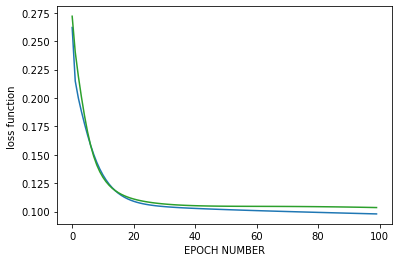

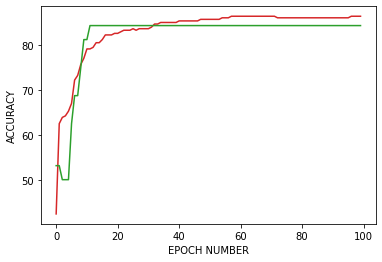

In [35]:
print(Xtrain.shape)
print(Ytrain.shape)


loss,accuracy,Vloss,Vaccuracy=cnn.Train(Xtrain,Ytrain,X_testVal,Y_testVal,0.01,100)
Show_Loss_Acc(loss,accuracy,Vloss,Vaccuracy)

In [26]:
print_predict(cnn,Xtrain,Ytrain)
print("::::::::::::::::::::::::::::")


np.round(cnn.Predict(np.array([0.51,0.35,0.14,0.02,0.2])))

Input:[0.12188842 0.66666667 0.43703704 1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[0.6 0.3]]
Input:[0.91978177 0.71428571 0.88148148 1.         0.        ]-- Real:[0. 1.] predict: [[0. 1.]] predict_float:[[0. 1.]]
 Input:[0.11294846 0.5        0.44444444 1.         0.        ]-- Real:[0. 1.] predict: [[1. 0.]] predict_float:[[0.84 0.11]]
Input:[0.71708771 0.26190476 0.5037037  1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[0.99 0.01]]
Input:[0.38849795 0.80952381 0.04444444 1.         0.        ]-- Real:[0. 1.] predict: [[0. 1.]] predict_float:[[0.02 0.98]]
Input:[0.19110269 0.73809524 0.52592593 0.         1.        ]-- Real:[0. 1.] predict: [[0. 1.]] predict_float:[[0.01 0.99]]
Input:[0.99725203 0.92857143 0.33333333 0.         1.        ]-- Real:[0. 1.] predict: [[0. 1.]] predict_float:[[0. 1.]]
Input:[0.49381405 0.28571429 0.25185185 0.         1.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[1. 0.]]
Input:[0.9792

Input:[0.40013358 0.         0.39259259 1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[1. 0.]]
Input:[0.84553425 0.4047619  0.44444444 0.         1.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[0.97 0.04]]
Input:[1.         0.64285714 0.85925926 1.         0.        ]-- Real:[0. 1.] predict: [[0. 1.]] predict_float:[[0.   0.99]]
Input:[0.35580393 0.19047619 0.01481481 1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[1. 0.]]
Input:[0.         0.4047619  0.31111111 1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[0.98 0.02]]
Input:[0.93407283 0.16666667 0.47407407 0.         1.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[1. 0.]]
Input:[0.75311712 0.45238095 0.48148148 1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[0.97 0.05]]
Input:[0.25367436 0.69047619 0.26666667 1.         0.        ]-- Real:[0. 1.] predict: [[0. 1.]] predict_float:[[0.09 0.9 ]]
Input:[0.903

Input:[0.06617662 0.52380952 0.34074074 0.         1.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[0.97 0.04]]
Input:[0.18001022 1.         0.22962963 1.         0.        ]-- Real:[0. 1.] predict: [[0. 1.]] predict_float:[[0.01 0.99]]
Input:[0.4181342  0.71428571 0.13333333 0.         1.        ]-- Real:[0. 1.] predict: [[0. 1.]] predict_float:[[0.01 0.99]]
Input:[0.88636757 0.26190476 0.5037037  1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[1. 0.]]
 Input:[0.33385637 0.54761905 0.47407407 0.         1.        ]-- Real:[1. 0.] predict: [[0. 1.]] predict_float:[[0.45 0.58]]
Input:[0.50340177 0.52380952 0.42222222 1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[0.96 0.11]]
Input:[0.5259971  0.66666667 0.05185185 1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[0.59 0.48]]
Input:[0.42276511 0.19047619 0.42222222 1.         0.        ]-- Real:[1. 0.] predict: [[1. 0.]] predict_float:[[1. 0.]]
Input:[

array([[1., 0.]])